Imports

In [2]:
import cv2
import copy
import numpy as np
from matplotlib import pyplot as plt

the convolution part

In [3]:
def apply_filter(input_image, kernal):
   
    output_image = []
    kernal_size = len(kernal)
    kernal_half = kernal_size // 2
    rows_count = len(input_image)

    image_copy = copy.deepcopy(input_image)


    for i in range(rows_count):
      for j in range(kernal_half): 
        image_copy[i].insert(0, input_image[i][-1-j])
        image_copy[i].append(input_image[i][j])
    for i in range(kernal_half):
        image_copy.append(image_copy[2*i])
        image_copy.insert(0, image_copy[-2-2*i].copy())


    new_rows_count = len(image_copy)
    new_columns_count = len(image_copy[0])

    for i in range(kernal_half, new_rows_count - kernal_half):
        output_row = []
        for j in range(kernal_half, new_columns_count - kernal_half):
            sum = 0
            for x in range(len(kernal)):
                for y in range(len(kernal)):
                    x1 = i + x - kernal_half
                    y1 = j + y - kernal_half
                    sum += image_copy[x1][y1] * kernal[x][y]
            output_row.append(sum)
        output_image.append(output_row)

    return output_image

kernal matrix for gaussian filtering

In [4]:
def get_kernal(kernal_size, sigma=1):
    gaussian_kernal = np.zeros((kernal_size, kernal_size), np.float32)
    size = kernal_size//2

    for x in range(-size, size+1):
        for y in range(-size, size+1):
            a = 1/(2*np.pi*(sigma**2))
            b = np.exp(-(x**2 + y**2)/(2* sigma**2))
            gaussian_kernal[x+size, y+size] = a*b
    return gaussian_kernal/gaussian_kernal.sum()

The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators.


In [5]:
def gradient_estimate(image):

  Mx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
  My = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

  X = apply_filter(image, Mx)
  Y = apply_filter(image, My)

  G = np.hypot(X, Y)
  G = G / G.max() * 255
  theta = np.arctan2(Y, X)
  
  return (G, theta)

the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.

In [6]:
def non_maxima_suppression(image, gradient_direction):
    rows_count = len(image)
    columns_count = len(image[0])

    output_image = np.zeros((rows_count, columns_count), dtype=np.int32)
    theta = gradient_direction * 180. / np.pi
    theta[theta < 0] += 180

    
    for i in range(1, rows_count-1):
        for j in range(1, columns_count-1):
            next = 255
            previous = 255
            if (0 <= theta[i,j] < 22.5) or (157.5 <= theta[i,j] <= 180):
                next = image[i, j+1]
                previous = image[i, j-1]
            elif (22.5 <= theta[i,j] < 67.5):
                next = image[i+1, j-1]
                previous = image[i-1, j+1]
            elif (67.5 <= theta[i,j] < 112.5):
                next = image[i+1, j]
                previous = image[i-1, j]
            elif (112.5 <= theta[i,j] < 157.5):
                next = image[i-1, j-1]
                previous = image[i+1, j+1]

            if (image[i,j] >= next) and (image[i,j] >= previous):
                output_image[i,j] = image[i,j]
            else:
                output_image[i,j] = 0
    
    return output_image

The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant

In [7]:
def double_threshold(image, low_threshold_ratio, high_threshold_ratio):
    
    high_threshold = image.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio
    
    rows_count = len(image)
    columns_count = len(image[0])
    output_image = np.zeros((rows_count, columns_count), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)

    strong_i = []
    strong_j = []
    weak_i = [] 
    weak_j = []
    for i in range (len(image)):
      for j in range (len(image[0])):
        if (image[i,j]>=high_threshold):
          strong_i.append(i)
          strong_j.append(j)
        if ((image[i,j] <= high_threshold) & (image[i,j] >= low_threshold)):
          weak_i.append(i)
          weak_j.append(j)
    strong_i = np.array(strong_i)
    strong_j = np.array(strong_j)
    weak_i = np.array(weak_i)
    weak_j = np.array(weak_j)
    
    output_image[strong_i, strong_j] = strong
    output_image[weak_i, weak_j] = weak


    
    return (output_image, weak, strong)

In [8]:
def hysteresis_edge_track(image, weak, strong=255):
    rows_count = len(image)
    columns_count = len(image[0]) 
    for i in range(1, rows_count-1):
        for j in range(1, columns_count-1):
            if (image[i,j] == weak):
                if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                    or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                    or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image

In [9]:
image = cv2.imread(r"D:\Mahesh\Coding files\edge_detection\test.png")

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernal = get_kernal(kernal_size=3)
noise_reduced_image = apply_filter(gray_image.tolist(), kernal)
G, theta = gradient_estimate(noise_reduced_image)

thin_edges = non_maxima_suppression(G, theta)

thick_edge, weak, strong = double_threshold(thin_edges, low_threshold_ratio = 0.05, high_threshold_ratio = 0.09)

final_image = hysteresis_edge_track(thick_edge, weak, strong=255)

In [10]:
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(final_image, cmap='gray')
plt.title("final image")

new_img = np.array(final_image, dtype='uint8')
new_img.shape
cv2.namedWindow('new_img')
cv2.imshow('gray_image',gray_image)
cv2.imshow('new_img',new_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Text(0.5, 1.0, 'final image')

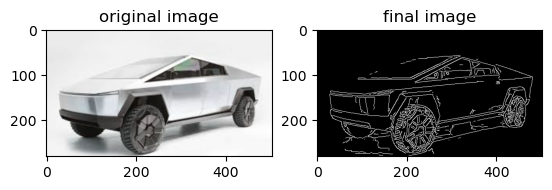

In [48]:
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(final_image, cmap='gray')
plt.title("final image")

Text(0.5, 1.0, 'final image')

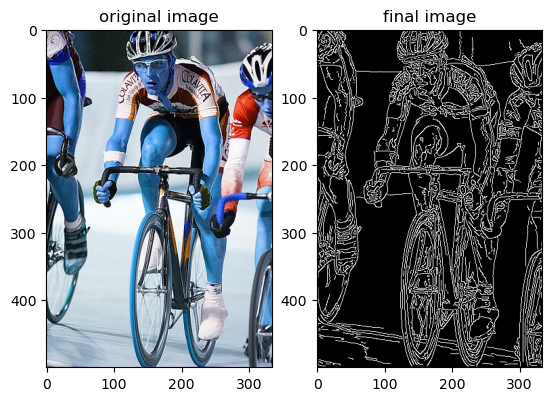

In [46]:
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(final_image, cmap='gray')
plt.title("final image")

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(final_image, cmap='gray')
plt.title("final image")